In [1]:
!pip install transformers

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.9 MB 882.6 kB/s eta 0:00:11
   -- ------------------------------------- 0.5/9.9 MB 882.6 kB/s eta 0:00:11
   ---- ----------------------------------- 1.0/9.9 MB 1.2 MB/s eta 0:00:08
   ------- -------------------------------- 1.8/9.9 MB 1.7 MB/s eta 0:00:05
   --------- ------------------------------ 2.4/9.9 MB 1.8 MB/s eta 0:00:05
   ---------- ----------------------------- 2.6/9.9 MB 1.8 MB/s eta 0:00:04
   ------------- -------------------------- 3.4/9.9 MB 2.0 MB/s eta 0:00:04
   --------------- ------------------------ 3.9/9.9 MB 2.1 MB/s eta 0:00:03
   ------------------ --------------------- 4.5/9.9 MB 2.1 MB/s eta 0:00:03
   -------------------- ------------------- 5.0/9.9 MB 2.2 MB/s eta 0:00:03
   ----------------------- ---------------- 5.8/9.9 MB 2.3 MB/s eta 0:00:02
   -------------------

In [4]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

num_classes = 40

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", num_labels=num_classes, ignore_mismatched_sizes=True)

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([40]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([40, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\prakh\anaconda3\envs\deeplearning\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\prakh\anaconda3\envs\deeplearning\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarni

In [9]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os

class SegmentationDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None, feature_extractor=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.image_files = []
        self.feature_extractor = feature_extractor 
        
        for batch_folder in os.listdir(image_folder):
            batch_path = os.path.join(image_folder, batch_folder)
            if os.path.isdir(batch_path):
                self.image_files += [os.path.join(batch_path, f) for f in os.listdir(batch_path) if f.endswith('_leftImg8bit.jpg')]
        
        if not self.image_files:
            raise ValueError("No images found in the image folder!")

        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img_name = os.path.basename(img_path)
        batch_name = os.path.basename(os.path.dirname(img_path))

        label_path = os.path.join(self.label_folder, batch_name, f"{img_name.split('_leftImg8bit')[0]}_gtFine_labelColors.png")
        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path).convert("L")  # Convert label to grayscale

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        # Apply feature extractor
        inputs = self.feature_extractor(images=image, return_tensors="pt")
        
        return inputs['pixel_values'].squeeze(), torch.tensor(label)

# Update transform to match model input requirements
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # SegFormer expects 512x512 input
    transforms.ToTensor()
])

train_folder = 'D:/New folder/Inter_Bootcamp/dataset/train'
labels_folder = 'D:/New folder/Inter_Bootcamp/dataset/labels'

# Create dataset and dataloader
dataset = SegmentationDataset(train_folder, labels_folder, transform=transform, feature_extractor=feature_extractor)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [16]:
!pip install tqdm

In [18]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import json
import segmentation_models_pytorch as smp
import torchmetrics.functional as tmf
from torchmetrics import JaccardIndex 
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split


# Optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = smp.losses.DiceLoss(mode='multiclass')

# Fine-tuning loop
from tqdm import tqdm
import torch.nn.functional as F

def save_checkpoint(model, optimizer, step, checkpoint_dir, checkpoint_name):
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    model.save_pretrained(os.path.join(checkpoint_path, 'model_transformer'))
    torch.save({
        'step': step,
        'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(checkpoint_path, 'optimizer.pt'))

# Training loop with tqdm for progress bar
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Wrap the dataloader with tqdm for the progress bar
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Remove channel dimension from labels (squeeze to make shape [batch_size, height, width])
        labels = labels.squeeze(1).long()

        # Forward pass
        outputs = model(images).logits  # Outputs shape: (batch_size, num_classes, 128, 128)

        # Upsample the outputs to match target size (batch_size, num_classes, 512, 512)
        outputs = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=False)

        # Compute loss
        loss = criterion(outputs, labels)

        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar with current loss
        progress_bar.set_postfix(loss=total_loss / len(progress_bar))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}")
    checkpoint_name = f'checkpoint_{epoch}'
    checkpoint_dir = 'D:/New folder/Inter_Bootcamp/checkpt'
    save_checkpoint(model, optimizer, epoch, checkpoint_dir, checkpoint_name)
    torch.save(model.state_dict(), f'D:/New folder/Inter_Bootcamp/model_weights_{epoch}.pth' )
    print(f'Model checkpoint saved at step {epoch}')

Epoch 1/10:   0%|          | 0/1759 [00:00<?, ?batch/s]C:\Users\prakh\AppData\Local\Temp\ipykernel_11136\161639473.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return inputs['pixel_values'].squeeze(), torch.tensor(label)
Epoch 1/10: 100%|██████████| 1759/1759 [35:21<00:00,  1.21s/batch, loss=0.235] 


Epoch 1/10, Loss: 0.23453033790511205


Epoch 2/10: 100%|██████████| 1759/1759 [28:28<00:00,  1.03batch/s, loss=0.00602]


Epoch 2/10, Loss: 0.006019271388604936


Epoch 3/10:  47%|████▋     | 832/1759 [13:53<15:29,  1.00s/batch, loss=0.001]   


KeyboardInterrupt: 

In [19]:
# Save the model after training
model.save_pretrained("./segformer_finetuned")

In [20]:
from transformers import SegformerForSemanticSegmentation

# Load the saved model
model = SegformerForSemanticSegmentation.from_pretrained("./segformer_finetuned")
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

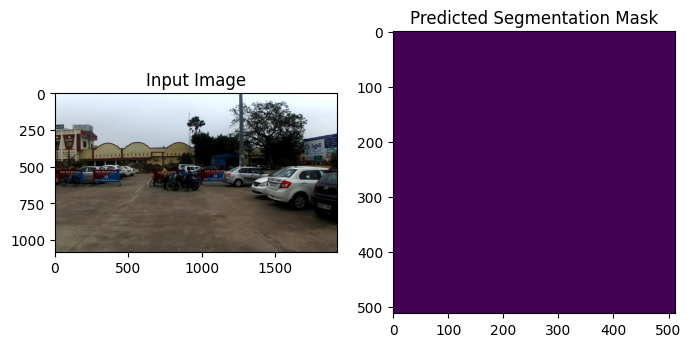

In [21]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = feature_extractor(images=image, return_tensors="pt")  # Use the feature extractor
    return image['pixel_values'].to(device)  # Move to the correct device

# Function to perform inference
def predict_segmentation(image_path):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        input_tensor = preprocess_image(image_path)  # Preprocess the image
        outputs = model(input_tensor).logits  # Get the model's output
        # Upsample the output to match the input image size
        outputs = F.interpolate(outputs, size=(512, 512), mode='bilinear', align_corners=False)  # Adjust this size as needed

        # Get predicted segmentation classes
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()  # Shape: (1, H, W)

    return predictions[0]  # Return the first batch (removing the batch dimension)

# Example usage
image_path = "D:/New folder/Inter_Bootcamp/dataset/test/frame0000_leftImg8bit.jpg"
predicted_mask = predict_segmentation(image_path)

# Visualize the predicted segmentation mask
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path).convert("RGB"))
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask)  # Visualize the segmentation mask
plt.title("Predicted Segmentation Mask")
plt.show()


In [23]:
def check_output_shape(image_path):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        input_tensor = preprocess_image(image_path)  # Preprocess the image
        outputs = model(input_tensor).logits  # Get the model's output
        print("Output shape:", outputs.shape)  # Check the shape of the output
        return outputs

# Example usage
outputs = check_output_shape("D:/New folder/Inter_Bootcamp/dataset/test/frame0000_leftImg8bit.jpg")

Output shape: torch.Size([1, 40, 128, 128])


Output shape: torch.Size([1, 40, 128, 128])


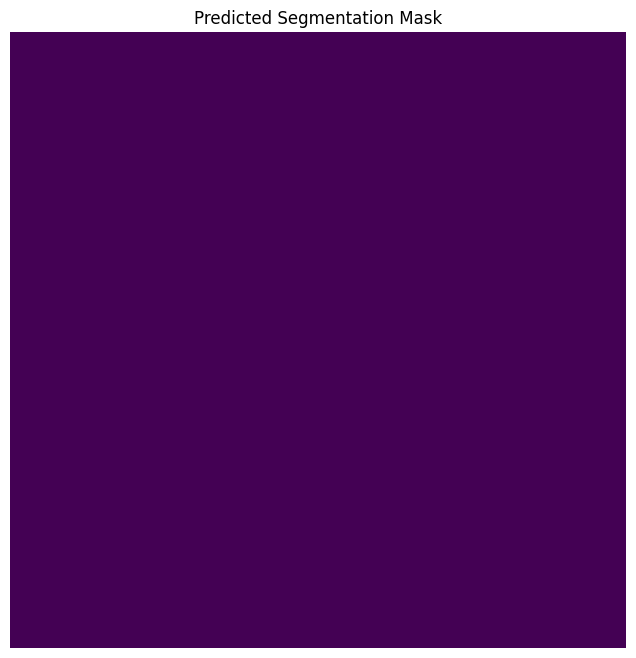

In [25]:
def predict_segmentation(image_path):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        input_tensor = preprocess_image(image_path)  # Preprocess the image
        outputs = model(input_tensor).logits  # Get the model's output

        # Check the output shape
        print("Output shape:", outputs.shape)

        # Upsample the outputs to match target size (this step may not be needed if input image size is correct)
        outputs = F.interpolate(outputs, size=(512, 512), mode='bilinear', align_corners=False)

        # Get predicted segmentation classes
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()  # Shape: (1, H, W)

    return predictions[0]  # Return the first batch (removing the batch dimension)

# Example usage
predicted_mask = predict_segmentation("D:/New folder/Inter_Bootcamp/dataset/test/frame0000_leftImg8bit.jpg")

# Visualize the predicted segmentation mask
plt.figure(figsize=(8, 8))
plt.imshow(predicted_mask)  # Visualize the segmentation mask
plt.title("Predicted Segmentation Mask")
plt.axis('off')
plt.show()


In [27]:
def check_logits_statistics(image_path):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        input_tensor = preprocess_image(image_path)  # Preprocess the image
        outputs = model(input_tensor).logits  # Get the model's output

        # Check the output shape and values
        print("Logits shape:", outputs.shape)  # Should be (1, num_classes, height, width)

        # Print statistics
        logits_np = outputs.cpu().numpy()  # Convert to numpy
        print("Logits min:", np.min(logits_np))
        print("Logits max:", np.max(logits_np))
        print("Logits mean:", np.mean(logits_np))
        print("Logits std:", np.std(logits_np))

# Example usage
check_logits_statistics("D:/New folder/Inter_Bootcamp/dataset/test/frame0000_leftImg8bit.jpg")


Logits shape: torch.Size([1, 40, 128, 128])
Logits min: -8.301156
Logits max: 6.946207
Logits mean: -4.8156877
Logits std: 1.643693


In [2]:
import torch
from transformers import SegformerForSemanticSegmentation

# Step 1: Initialize the model (using SegformerForSemanticSegmentation)
num_classes = 40  # Specify the number of classes for your task
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512", 
    num_labels=num_classes, 
    ignore_mismatched_sizes=True
)

# Step 2: Load the state dictionary
model.load_state_dict(torch.load("D:/Inter_Bootcamp/model_weights_0.pth"))

# Step 3: Set the model to evaluation mode
model.eval()

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([40]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([40, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\prakh\AppData\Local\Temp\ipykernel_10212\19832532.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). 

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [47]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import json
import pandas as pd
import cv2
import numpy as np
import helper

labels_list = [
    ('road', 0, 7, 0, 0, 0, 'drivable', 0, 0, False, False, (128, 64, 128)),
    ('parking', 1, 9, 255, 1, 1, 'drivable', 1, 0, False, False, (250, 170, 160)),
    ('drivable fallback', 2, 255, 255, 2, 1, 'drivable', 1, 0, False, False, (81, 0, 81)),
    ('sidewalk', 3, 8, 1, 3, 2, 'non-drivable', 2, 1, False, False, (244, 35, 232)),
    ('rail track', 4, 10, 255, 3, 3, 'non-drivable', 3, 1, False, False, (230, 150, 140)),
    ('non-drivable fallback', 5, 255, 9, 4, 3, 'non-drivable', 3, 1, False, False, (152, 251, 152)),
    ('person', 6, 24, 11, 5, 4, 'living-thing', 4, 2, True, False, (220, 20, 60)),
    ('animal', 7, 255, 255, 6, 4, 'living-thing', 4, 2, True, True, (246, 198, 145)),
    ('rider', 8, 25, 12, 7, 5, 'living-thing', 5, 2, True, False, (255, 0, 0)),
    ('motorcycle', 9, 32, 17, 8, 6, '2-wheeler', 6, 3, True, False, (0, 0, 230)),
    ('bicycle', 10, 33, 18, 9, 7, '2-wheeler', 6, 3, True, False, (119, 11, 32)),
    ('autorickshaw', 11, 255, 255, 10, 8, 'autorickshaw', 7, 3, True, False, (255, 204, 54)),
    ('car', 12, 26, 13, 11, 9, 'car', 7, 3, True, False, (0, 0, 142)),
    ('truck', 13, 27, 14, 12, 10, 'large-vehicle', 8, 3, True, False, (0, 0, 70)),
    ('bus', 14, 28, 15, 13, 11, 'large-vehicle', 8, 3, True, False, (0, 60, 100)),
    ('caravan', 15, 29, 255, 14, 12, 'large-vehicle', 8, 3, True, True, (0, 0, 90)),
    ('trailer', 16, 30, 255, 15, 12, 'large-vehicle', 8, 3, True, True, (0, 0, 110)),
    ('train', 17, 31, 16, 15, 12, 'large-vehicle', 8, 3, True, True, (0, 80, 100)),
    ('vehicle fallback', 18, 355, 255, 15, 12, 'large-vehicle', 8, 3, True, False, (136, 143, 153)),
    ('curb', 19, 255, 255, 16, 13, 'barrier', 9, 4, False, False, (220, 190, 40)),
    ('wall', 20, 12, 3, 17, 14, 'barrier', 9, 4, False, False, (102, 102, 156)),
    ('fence', 21, 13, 4, 18, 15, 'barrier', 10, 4, False, False, (190, 153, 153)),
    ('guard rail', 22, 14, 255, 19, 16, 'barrier', 10, 4, False, False, (180, 165, 180)),
    ('billboard', 23, 255, 255, 20, 17, 'structures', 11, 4, False, False, (174, 64, 67)),
    ('traffic sign', 24, 20, 7, 21, 18, 'structures', 11, 4, False, False, (220, 220, 0)),
    ('traffic light', 25, 19, 6, 22, 19, 'structures', 11, 4, False, False, (250, 170, 30)),
    ('pole', 26, 17, 5, 23, 20, 'structures', 12, 4, False, False, (153, 153, 153)),
    ('polegroup', 27, 18, 255, 23, 20, 'structures', 12, 4, False, False, (153, 153, 153)),
    ('obs-str-bar-fallback', 28, 255, 255, 24, 21, 'structures', 12, 4, False, False, (169, 187, 214)),
    ('building', 29, 11, 2, 25, 22, 'construction', 13, 5, False, False, (70, 70, 70)),
    ('bridge', 30, 15, 255, 26, 23, 'construction', 13, 5, False, False, (150, 100, 100)),
    ('tunnel', 31, 16, 255, 26, 23, 'construction', 13, 5, False, False, (150, 120, 90)),
    ('vegetation', 32, 21, 8, 27, 24, 'vegetation', 14, 5, False, False, (107, 142, 35)),
    ('sky', 33, 23, 10, 28, 25, 'sky', 15, 6, False, False, (70, 130, 180)),
    ('fallback background', 34, 255, 255, 29, 25, 'object fallback', 15, 6, False, False, (169, 187, 214)),
    ('unlabeled', 35, 0, 255, 255, 255, 'void', 255, 255, False, True, (0, 0, 0)),
    ('ego vehicle', 36, 1, 255, 255, 255, 'void', 255, 255, False, True, (0, 0, 0)),
    ('rectification border', 37, 2, 255, 255, 255, 'void', 255, 255, False, True, (0, 0, 0)),
    ('out of roi', 38, 3, 255, 255, 255, 'void', 255, 255, False, True, (0, 0, 0)),
    ('license plate', 39, 255, 255, 255, 255, 'vehicle', 255, 255, False, True, (0, 0, 142)),
]

# Custom dataset for test set
class TestDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_path

# Function to pad image to be divisible by 32
def pad_image(img):
    c, h, w = img.shape  # Correct shape unpacking
    new_h = ((h // 32) + 1) * 32 if h % 32 != 0 else h
    new_w = ((w // 32) + 1) * 32 if w % 32 != 0 else w
    padded_img = torch.zeros((c, new_h, new_w))
    padded_img[:, :h, :w] = img
    return padded_img

# Function to convert the segmented image into polygon-based format and prepare for CSV
def image_to_polygon_format(segmented_image):
    # Assuming segmented_image is of shape (height, width, num_classes)
    height, width, num_classes = segmented_image.shape
    objects = []  # To hold the polygon data for each object

    for label_idx, label in enumerate(labels_list):
        if label[10]:
            continue  # Skip labels that should be ignored

        # Extract the specific class channel
        class_channel = segmented_image[:, :, label_idx]

        # Threshold to create binary mask
        mask = (class_channel > 0.5).astype(np.uint8) * 255  # Convert to 0-255 mask

        # Find contours (polygons) in the binary mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if len(contour) < 3:  # Skip small or invalid polygons
                continue

            # Simplify the contour to polygon format
            polygon = contour.reshape(-1, 2).tolist()  # Flatten the contour to a list of points

            # Create the object data for the current label and polygon
            object_data = {
                "label": label[0],
                "polygon": polygon
            }

            # Append the object to the result
            objects.append(object_data)

    return objects

# Function to save to the CSV format as requested
def save_to_csv(objects_dict, output_csv_path):
    # Create a DataFrame with id and objects
    data = [{"id": filename, "objects": json.dumps(objects)} for filename, objects in objects_dict.items()]
    df = pd.DataFrame(data)
    
    # Save to CSV
    df.to_csv(output_csv_path, index=False)

# Function to run inference
def run_inference(model, test_loader):
    model.eval()
    results = []
    
    for img, img_path in test_loader:
        img = pad_image(img.squeeze(0))  # Pad the image and remove batch dimension
        filename = os.path.basename(img_path[0]).replace('_leftImg8bit.jpg', '')
        
        # Forward pass through the model
        with torch.no_grad():
            output = model(img.unsqueeze(0))  # Get model output (SemanticSegmenterOutput)
        
        # Access the logits from the output
        logits = output.logits
        
        # Move the logits tensor to CPU and convert to numpy
        logits_cpu = logits.cpu().numpy()
        
        segmented_image = logits_cpu[0].transpose(1, 2, 0)  # Convert to HWC (Height-Width-Channels)
        objects = image_to_polygon_format(segmented_image)  # Convert to polygons
        
        # Append results (you might need to adjust this depending on your task)
        results.append({"filename": filename, "objects": objects})
    
    return results


# Load your trained model
#model = OurModel()
#model.load_state_dict(torch.load('trained_model.pth'))
#model.eval()

# Create a DataLoader for your test set
test_files = [os.path.join("D:/New folder/Inter_Bootcamp/dataset/test", f) for f in os.listdir("D:/New folder/Inter_Bootcamp/dataset/test") if f.endswith('_leftImg8bit.jpg')]
test_dataset = TestDataset(test_files, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Run inference
results = run_inference(model, test_loader)

# Save results to submission file
save_to_csv(results, 'submission_3.csv')
print("Submission 3 file created successfully.")

KeyboardInterrupt: 

In [43]:
labels_list = [
    ('road', 0, 7, 0, 0, 0, 'drivable', 0, 0, False, False, (128, 64, 128)),
    ('parking', 1, 9, 255, 1, 1, 'drivable', 1, 0, False, False, (250, 170, 160)),
    ('drivable fallback', 2, 255, 255, 2, 1, 'drivable', 1, 0, False, False, (81, 0, 81)),
    ('sidewalk', 3, 8, 1, 3, 2, 'non-drivable', 2, 1, False, False, (244, 35, 232)),
    ('rail track', 4, 10, 255, 3, 3, 'non-drivable', 3, 1, False, False, (230, 150, 140)),
    ('non-drivable fallback', 5, 255, 9, 4, 3, 'non-drivable', 3, 1, False, False, (152, 251, 152)),
    ('person', 6, 24, 11, 5, 4, 'living-thing', 4, 2, True, False, (220, 20, 60)),
    ('animal', 7, 255, 255, 6, 4, 'living-thing', 4, 2, True, True, (246, 198, 145)),
    ('rider', 8, 25, 12, 7, 5, 'living-thing', 5, 2, True, False, (255, 0, 0)),
    ('motorcycle', 9, 32, 17, 8, 6, '2-wheeler', 6, 3, True, False, (0, 0, 230)),
    ('bicycle', 10, 33, 18, 9, 7, '2-wheeler', 6, 3, True, False, (119, 11, 32)),
    ('autorickshaw', 11, 255, 255, 10, 8, 'autorickshaw', 7, 3, True, False, (255, 204, 54)),
    ('car', 12, 26, 13, 11, 9, 'car', 7, 3, True, False, (0, 0, 142)),
    ('truck', 13, 27, 14, 12, 10, 'large-vehicle', 8, 3, True, False, (0, 0, 70)),
    ('bus', 14, 28, 15, 13, 11, 'large-vehicle', 8, 3, True, False, (0, 60, 100)),
    ('caravan', 15, 29, 255, 14, 12, 'large-vehicle', 8, 3, True, True, (0, 0, 90)),
    ('trailer', 16, 30, 255, 15, 12, 'large-vehicle', 8, 3, True, True, (0, 0, 110)),
    ('train', 17, 31, 16, 15, 12, 'large-vehicle', 8, 3, True, True, (0, 80, 100)),
    ('vehicle fallback', 18, 355, 255, 15, 12, 'large-vehicle', 8, 3, True, False, (136, 143, 153)),
    ('curb', 19, 255, 255, 16, 13, 'barrier', 9, 4, False, False, (220, 190, 40)),
    ('wall', 20, 12, 3, 17, 14, 'barrier', 9, 4, False, False, (102, 102, 156)),
    ('fence', 21, 13, 4, 18, 15, 'barrier', 10, 4, False, False, (190, 153, 153)),
    ('guard rail', 22, 14, 255, 19, 16, 'barrier', 10, 4, False, False, (180, 165, 180)),
    ('billboard', 23, 255, 255, 20, 17, 'structures', 11, 4, False, False, (174, 64, 67)),
    ('traffic sign', 24, 20, 7, 21, 18, 'structures', 11, 4, False, False, (220, 220, 0)),
    ('traffic light', 25, 19, 6, 22, 19, 'structures', 11, 4, False, False, (250, 170, 30)),
    ('pole', 26, 17, 5, 23, 20, 'structures', 12, 4, False, False, (153, 153, 153)),
    ('polegroup', 27, 18, 255, 23, 20, 'structures', 12, 4, False, False, (153, 153, 153)),
    ('obs-str-bar-fallback', 28, 255, 255, 24, 21, 'structures', 12, 4, False, False, (169, 187, 214)),
    ('building', 29, 11, 2, 25, 22, 'construction', 13, 5, False, False, (70, 70, 70)),
    ('bridge', 30, 15, 255, 26, 23, 'construction', 13, 5, False, False, (150, 100, 100)),
    ('tunnel', 31, 16, 255, 26, 23, 'construction', 13, 5, False, False, (150, 120, 90)),
    ('vegetation', 32, 21, 8, 27, 24, 'vegetation', 14, 5, False, False, (107, 142, 35)),
    ('sky', 33, 23, 10, 28, 25, 'sky', 15, 6, False, False, (70, 130, 180)),
    ('fallback background', 34, 255, 255, 29, 25, 'object fallback', 15, 6, False, False, (169, 187, 214)),
    ('unlabeled', 35, 0, 255, 255, 255, 'void', 255, 255, False, True, (0, 0, 0)),
    ('ego vehicle', 36, 1, 255, 255, 255, 'void', 255, 255, False, True, (0, 0, 0)),
    ('rectification border', 37, 2, 255, 255, 255, 'void', 255, 255, False, True, (0, 0, 0)),
    ('out of roi', 38, 3, 255, 255, 255, 'void', 255, 255, False, True, (0, 0, 0)),
    ('license plate', 39, 255, 255, 255, 255, 'vehicle', 255, 255, False, True, (0, 0, 142)),
]

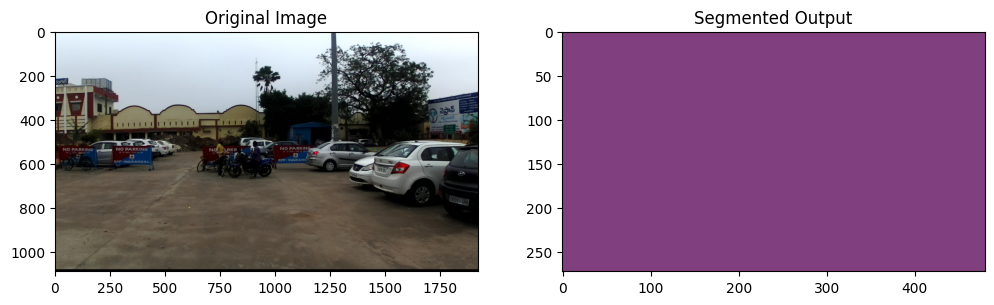

In [44]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming labels_list is already defined

# Function to pad image to be divisible by 32
def pad_image(img):
    c, h, w = img.shape
    new_h = ((h // 32) + 1) * 32 if h % 32 != 0 else h
    new_w = ((w // 32) + 1) * 32 if w % 32 != 0 else w
    padded_img = torch.zeros((c, new_h, new_w))
    padded_img[:, :h, :w] = img
    return padded_img

# Function to visualize segmented output
def visualize_segmented_output(image, segmented_image, labels_list):
    predicted_labels = np.argmax(segmented_image, axis=-1)  # Convert logits to class indices
    
    visual_image = np.zeros((predicted_labels.shape[0], predicted_labels.shape[1], 3), dtype=np.uint8)
    
    for label in labels_list:
        color = label[11]  # Get the color from the labels_list
        label_id = label[1]
        visual_image[predicted_labels == label_id] = color
        

    # Display the original image and segmented output
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))  # Convert image from CHW to HWC format
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(visual_image)
    plt.title('Segmented Output')
    
    plt.show()

# Function to run inference on a single image
def run_inference_on_single_image(model, image_path, labels_list):
    model.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.ToTensor()
    img_tensor = transform(image)
    
    # Pad the image to be divisible by 32
    img_tensor = pad_image(img_tensor)
    
    # Forward pass through the model
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0))  # Add batch dimension
    
    logits = output.logits.cpu().numpy()
    
    
    # Convert the output logits to a segmented image
    segmented_image = logits[0].transpose(1, 2, 0)  # Convert to HWC
    
    # Visualize the output
    visualize_segmented_output(img_tensor, segmented_image, labels_list)

# Load your model
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", num_labels=num_classes)
# model.eval()

# Run inference on a single image
image_path = 'D:/New folder/Inter_Bootcamp/dataset/test/frame0000_leftImg8bit.jpg'  # Replace with your image path
run_inference_on_single_image(model, image_path, labels_list)


SemanticSegmenterOutput(loss=None, logits=tensor([[[[ 6.7115,  7.0338,  7.2824,  ...,  7.1706,  7.1404,  7.1558],
          [ 7.0089,  7.0252,  7.1969,  ...,  7.0914,  7.0715,  6.9336],
          [ 7.1642,  7.2241,  7.3093,  ...,  7.1963,  7.1808,  7.0418],
          ...,
          [ 6.5690,  6.8232,  6.9219,  ...,  6.7112,  6.6127,  6.5839],
          [ 6.6512,  6.8498,  7.0037,  ...,  6.7318,  6.5760,  6.5771],
          [ 6.9199,  7.0284,  7.1359,  ...,  6.8458,  6.6531,  6.6343]],

         [[-6.7594, -7.0685, -7.2949,  ..., -7.3036, -7.2648, -7.3098],
          [-7.0450, -6.9953, -7.1832,  ..., -7.1769, -7.1523, -6.9881],
          [-7.1805, -7.2090, -7.3135,  ..., -7.2883, -7.2714, -7.1148],
          ...,
          [-6.6008, -6.7732, -6.8665,  ..., -6.6588, -6.5697, -6.4807],
          [-6.6976, -6.8442, -6.9653,  ..., -6.7078, -6.5802, -6.5980],
          [-6.9213, -6.9758, -7.0662,  ..., -6.7893, -6.6390, -6.6195]],

         [[-6.5510, -6.8293, -7.0573,  ..., -6.9180, -6.9066

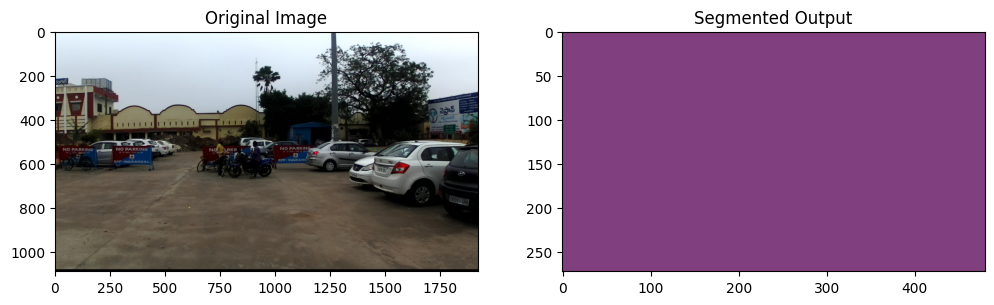

In [49]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def pad_image(img):
    c, h, w = img.shape
    new_h = ((h // 32) + 1) * 32 if h % 32 != 0 else h
    new_w = ((w // 32) + 1) * 32 if w % 32 != 0 else w
    padded_img = torch.zeros((c, new_h, new_w))
    padded_img[:, :h, :w] = img
    return padded_img

# Function to visualize segmented output
def visualize_segmented_output(image, segmented_image, labels_list):

    predicted_labels = np.argmax(segmented_image, axis=-1)  
    print(predicted_labels)
    
    visual_image = np.zeros((predicted_labels.shape[0], predicted_labels.shape[1], 3), dtype=np.uint8)
    
    # Map each predicted label to its corresponding color
    for label in labels_list:
        color = label[11]  # Get the color from the labels_list
        label_id = label[1]
        visual_image[predicted_labels == label_id] = color
        
    # Display the original image and segmented output
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))  # Convert image from CHW to HWC format
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(visual_image)
    plt.title('Segmented Output')
    
    plt.show()

# Function to run inference on a single image
def run_inference_on_single_image(model, image_path, labels_list):
    model.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.ToTensor()
    img_tensor = transform(image)
    
    # Pad the image to be divisible by 32
    img_tensor = pad_image(img_tensor)
    
    # Forward pass through the model
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0))  # Add batch dimension
    print(output)
    # Extract logits and move them to the CPU
    logits = output.logits.cpu().numpy()
    
    # Convert the output logits to a segmented image
    # Shape of logits: (1, num_classes, height, width), we need to make it (height, width, num_classes)
    segmented_image = logits[0].transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    
    #print(segmented_image)
    
    # Visualize the output
    visualize_segmented_output(img_tensor, segmented_image, labels_list)

# Ensure the model is loaded correctly and is in evaluation mode
# Example model loading, replace with your actual model
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", num_labels=num_classes)
# model.eval()

# Run inference on a single image
image_path = 'D:/New folder/Inter_Bootcamp/dataset/test/frame0000_leftImg8bit.jpg'  # Replace with your image path
run_inference_on_single_image(model, image_path, labels_list)